## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
print(f'период с {df.index.min()} по {df.index.max()}')

период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00


В данном датасете 26496 строк 1 столбец. При загрузке датасета мы дату сразу перевели в формат DateTime и поместили его в индекс. Наш датасет представлей за период с 2018-03-01 по 2018-08-31. Целевой признак-num_orders- количество заказов.

Отсортируем и сгруппируем по часам. В num_orders поместим сумму заказов за час

In [6]:
df.sort_index(inplace=True)
df=df['2018-03':'2018-08'].resample('1H').sum()

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

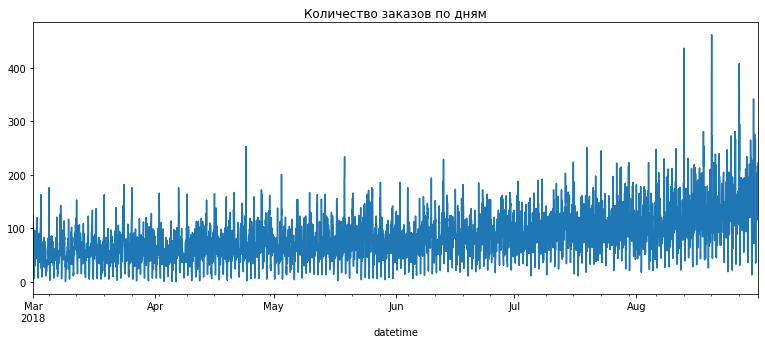

In [8]:
plt.figure(figsize=(13,5))
plt.title('Количество заказов по дням')
df['num_orders'].plot()

Временной ряд не стационарен. Со временем меняется его среднее значение и дисперсия.

In [9]:
# Создадим столбец со скользящим средним и окном 10.
df['rolling_mean']=df['num_orders'].rolling(window=10).mean()
df=df.fillna(0)

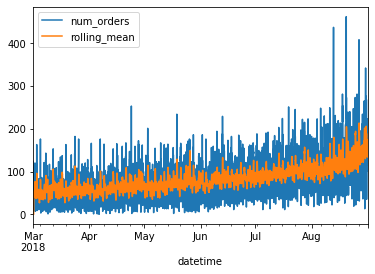

In [10]:
df.plot()

In [11]:
# Произвожу декомпозицию временного ряда, что увидеть тренд, сезонность и белый шум
decomposed = seasonal_decompose(df['num_orders'])

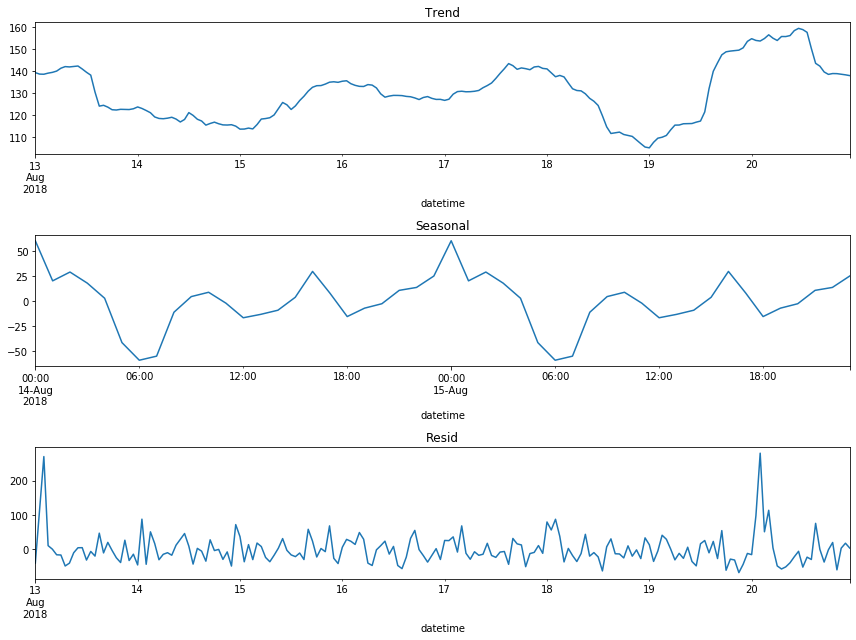

In [12]:
plt.figure(figsize=(12, 9))
plt.subplot(311)

decomposed.trend['2018-08-13':'2018-08-20'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)

decomposed.seasonal['2018-08-14':'2018-08-15'].plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)

decomposed.resid['2018-08-13':'2018-08-20'].plot(ax=plt.gca())
plt.title('Resid')
plt.tight_layout()

В тренде виделил участок в неделю, можно наблюдать, как меняется количество заказов в течении недели. Шум как и положенно с средним отклонением в райне 0. По сезонности можно увидеть как меняется количество заказов в течении дня и наблюдать повторяемость этого на следующие дни.

Для дальнейшего прогнозирования временного ряда, нам понадобится преобразовать его стационарный

In [13]:
df=df-df.shift(fill_value=0)

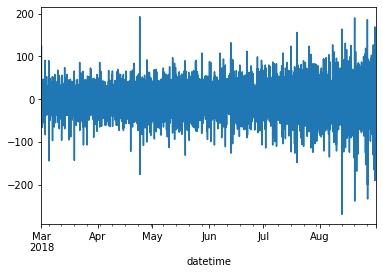

In [14]:
df['num_orders'].plot()

Ряд стал более стационарен. Среднее значение в целом одинаковое, но дисперсия немного скачет. Стало лучше. Такой ряд можно прогнозировать.

# 3. Обучение

Подготовим функцию для создания календарных признаков и отстающих значений

In [15]:
def make_features(df, max_lag, rolling_mean_size):

    df['Day_of_week']=df.index.dayofweek
    df['Hour']=df.index.hour
    
    for i in range(1,max_lag+1):
        df['lag_{}'.format(i)]=df['num_orders'].shift(i)
    df['rolling_mean']=df['num_orders'].shift().rolling(window=rolling_mean_size).mean()
    return df

Создали следующие признаки:

- день недели. Фактор дня недели. День недели сильно можнт влиять на загруженность трафика, потому что какие то дни бвдние, а какие то выходные. 
- час. Фактор часа дает информацию на определенный период
- lag нужен как показатель будут ли даннве расти
- rolling задаёт общий тренд временного ряда

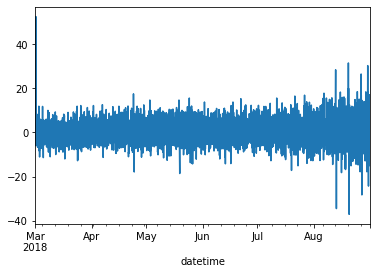

In [16]:
df['rolling_mean'].plot()

### model LinearRegression

In [17]:
df_line=df.copy()

best_rmse={}

#for i in range(1,30):
#    for j in range(1,30):
df_line=make_features(df_line,23,26)

train, test = train_test_split(df_line, shuffle=False, test_size=0.2)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
        
model = LinearRegression().fit(features_train,target_train)
predict = model.predict(features_test)
        
RMSE_line=np.sqrt(mean_squared_error(predict,target_test))
#best_rmse[RMSE_line] = [i,j]
#print('-'*10)
#print('Лучшее значение')
#print(f'lag->{best_rmse[min(best_rmse.keys())][0]}, rolling_mean->{best_rmse[min(best_rmse.keys())][1]}, RMSE->{min(best_rmse.keys())}')

Лучшие значения для LinearRegression
- lag ->23
- rolling -> 26

где RMSE -> 39.65

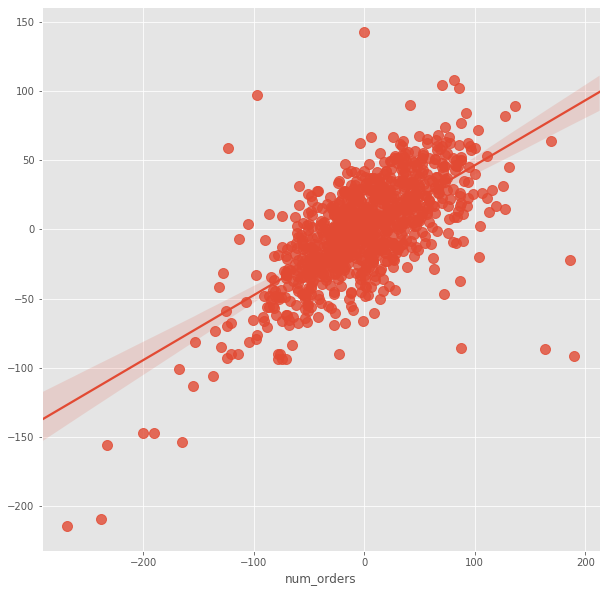

In [18]:
plt.style.use('ggplot') 
plt.figure( figsize= (10 , 10 )) 
sns.regplot(target_test,  predict,  fit_reg= True,  scatter_kws= {"s":  100 })

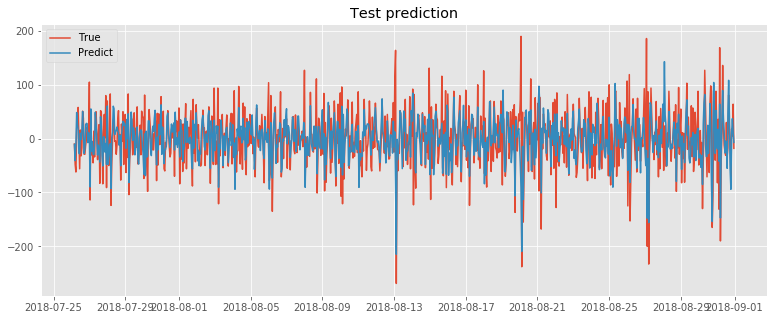

In [19]:
plt.figure(figsize=(13, 5))

plt.plot(target_test, label='True')
plt.plot(target_test.index, predict, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.show()

### model RandomForestRegressor

Берем такие же lag и rolling из лучших значений Линейной регрессии

In [20]:
df_random_forest=df.copy()
df_random_forest=make_features(df_random_forest,23,26)

In [21]:
train, test = train_test_split(df_random_forest, shuffle=False, test_size=0.2)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [22]:
# Подбираяю лучший гиперпараметр max_depth
best_rmse_random_forset={}
#for n_estim in range(1,100):
#    for max_depth in range(1,20):
model=RandomForestRegressor(n_estimators=92,max_depth=14,random_state=1234).fit(features_train,target_train)
predict=model.predict(features_test)
rmse_forest = np.sqrt(mean_squared_error(predict,target_test))
#best_rmse_random_forset[rmse_forest] = [n_estim,max_depth]
print(f'RMSE->{rmse_forest}')
        
#print('Лучшее значение')
#print(f'n_estimators->{best_rmse_random_forset[min(best_rmse_random_forset.keys())][0]}, max_depth->{best_rmse_random_forset[min(best_rmse_random_forset.keys())][1]}, RMSE->{min(best_rmse_random_forset.keys())}')
        

RMSE->42.58604584971975


Лучшие значения для RandomForest
- n_estimators->92
- max_depth->14

где RMSE -> 46.612865822430386

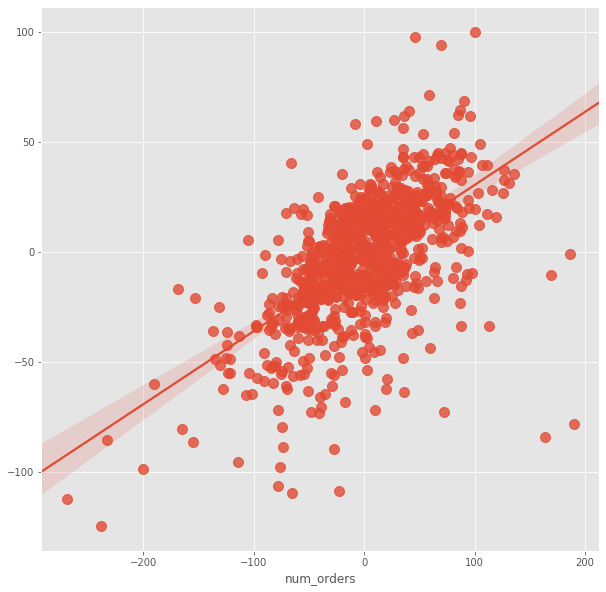

In [23]:
plt.style.use('ggplot') 
plt.figure( figsize= (10 , 10 )) 
sns.regplot(target_test,  predict,  fit_reg= True,  scatter_kws= {"s":  100 })

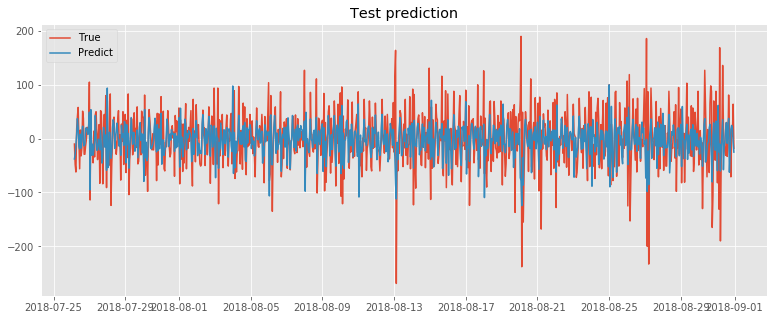

In [24]:
plt.figure(figsize=(13, 5))

plt.plot(target_test, label='True')
plt.plot(target_test.index, predict, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.show()

### CatBoostRegressor

In [25]:
df_cat=df.copy()
df_cat=make_features(df_cat,23,26)

In [26]:
train, test = train_test_split(df_cat, shuffle=False, test_size=0.2)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [27]:
the_best_cat = {}
#for i in range(100,800,100):
#    for j in range(1,12,2):
model_cat=CatBoostRegressor(depth=7,
                        iterations=700,
                        learning_rate=0.1,
                        loss_function='RMSE').fit(features_train,target_train,verbose=100)

predict=model_cat.predict(features_test)
rmse=mean_squared_error(predict,target_test)
#the_best_cat[np.sqrt(rmse)] = [j, i]
print(f'RMSE: {np.sqrt(rmse)}')

0:	learn: 33.6275251	total: 52.4ms	remaining: 36.6s
100:	learn: 19.1908702	total: 3.79s	remaining: 22.5s
200:	learn: 14.2652542	total: 7.46s	remaining: 18.5s
300:	learn: 11.2832642	total: 11.2s	remaining: 14.9s
400:	learn: 9.2929223	total: 15s	remaining: 11.2s
500:	learn: 7.6135099	total: 18.7s	remaining: 7.44s
600:	learn: 6.3168938	total: 22.5s	remaining: 3.7s
699:	learn: 5.3017900	total: 26.8s	remaining: 0us
RMSE: 40.66572685579435


In [28]:
#print('Лучшее значение cat_boost')
#print(f'depth->{the_best_cat[min(the_best_cat.keys())][0]}, iterations->{the_best_cat[min(the_best_cat.keys())][1]}, RMSE->{min(the_best_cat.keys())}')


Лучшие значения для CatBoostRegressor
- depth->7
- iterations->700
- learning_rate->0.1

где RMSE -> 42.86712760283131

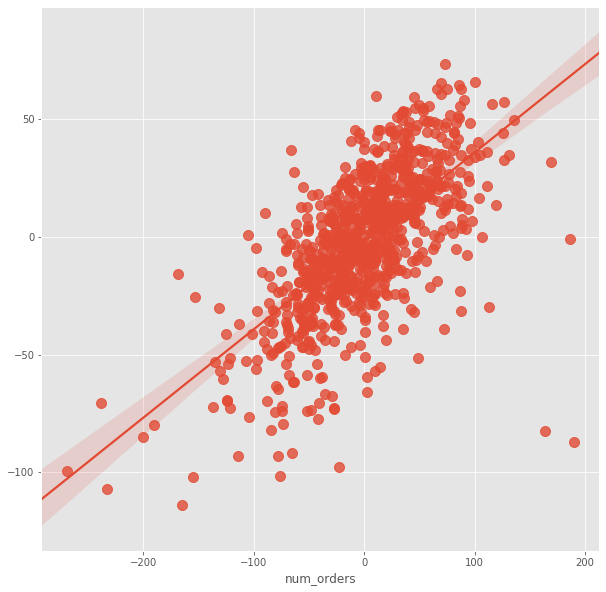

In [29]:
plt.style.use('ggplot') 
plt.figure( figsize= (10 , 10 )) 
sns.regplot(target_test,  predict,  fit_reg= True,  scatter_kws= {"s":  100 })

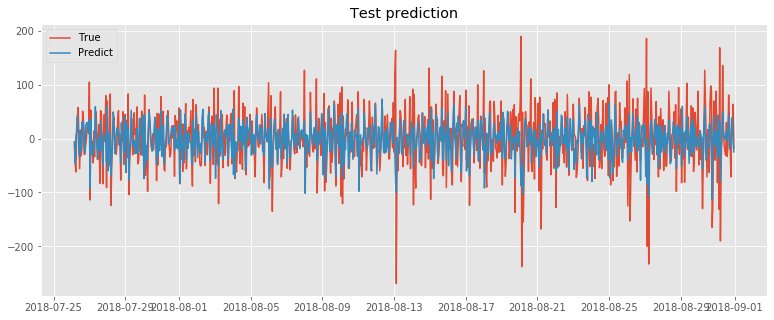

In [30]:
plt.figure(figsize=(13, 5))

plt.plot(target_test, label='True')
plt.plot(target_test.index, predict, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.show()

# 4. Тестирование

In [31]:
np.array([RMSE_line,rmse_forest,np.sqrt(rmse)])

array([39.82689606, 42.58604585, 40.66572686])

In [32]:
df_rezult=pd.DataFrame(np.array([RMSE_line,rmse_forest,np.sqrt(rmse)]),index=['LinearRegression','RandomForestRegressor','CatBoostRegressor'])
df_rezult.set_axis(['RMSE'],axis='columns',inplace=True)
df_rezult

,RMSE
LinearRegression,39.826896
RandomForestRegressor,42.586046
CatBoostRegressor,40.665727


# Вывод

По всем трем моделям я получил показатель RMSE не больше 48. Можно выделить, что LinearRegression показала себя лучше всех. Я не прогонял циклом lag и скользящее среднее для RandomForest и CatBoostRegressor. Думаю, что если бы это сделал, то результат был бы лучше. Но время расчета для этих моделей очень большое, поэтому я не стал это делать.